Оформляем единый github-репозиторий, в котором представлены результаты всех 3 лабораторных работ. Github-репозиторий должен иметь модульную структуру, jupyter-notebook, в котором даны комментарии к каждой ячейке с кодом и readme.


**Лабораторная работа №6 (Проведение исследований с моделями классификации)**
1.	Выбор начальных условий

a.	Выбрать набор данных для задачи классификации (у каждого студента должен быть уникальный набор данных) и обосновать его выбор (реальная практическая задача)  
b.	Выбрать метрики качества и обосновать их выбор  

2.	Создание бейзлайна и оценка качества

a.	Обучить модели (как сверточные так и «трансформерные») из torchvision для выбранного набора данных  
b.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных  

3.	Улучшение бейзлайна

a.	Сформулировать гипотезы (аугментации данных, подбор моделей, подбор гиперпараметров и т.д.)  
b.	Проверить гипотезы  
c.	Сформировать улучшенный бейзлайн по результатам проверки гипотез  
d.	Обучить модели с улучшенным бейзлайном на выбранном наборе данных  
e.	Оценить качество моделей с улучшенным бейзлайном по выбранным метрикам на выбранном наборе данных  
f.	Сравнить результаты моделей с улучшенным бейзлайном в сравнении с результатами из пункта 2   
g.	Сделать выводы  

4.	Имплементация алгоритма машинного обучения

a.	Самостоятельно имплементировать модели машинного обучения   
b.	Обучить имплементированные модели на выбранном наборе данных  
c.	Оценить качество имплементированных моделей по выбранным метрикам на выбранном наборе данных  
d.	Сравнить результаты имплементированных моделей в сравнении с результатами из пункта 2  
e.	Сделать выводы  
f.	Добавить техники из улучшенного бейзлайна (пункт 3с)  
g.	Обучить модели для выбранных наборов данных  
h.	Оценить качество моделей по выбранным метрикам на выбранном наборе данных  
i.	Сравнить результаты моделей в сравнении с результатами из пункта 3  
j.	Сделать выводы  


**Лабораторная работа №7 (Проведение исследований моделями семантической сегментации)** – повторить пункты 2-4 из лабораторной работы №6, но использовать segmentation_models.pytorch вместо torchvision


**Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)** – повторить пункты 2-4 из лабораторной работы №6, но использовать ultralytics (семейство моделей YOLOv11) вместо torchvision

# **Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)**

## 1. Выбор начальных условий

### a. Набор данных

Был выбран датасет [Car Object Detection](https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data) (детекция автомобилей на изображениях). Этот датасет имеет широкий спектр практических применений, таких как системы видеонаблюдения для мониторинга дорожного движения, автоматизированные парковочные системы, а также инструменты анализа трафика для подсчёта автомобилей и выявления пробок.

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

# URL датасета на Kaggle
dataset_url = "https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data"

# Загрузка датасета
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fedor7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection


### b. Метрики качества

Для детекции стандартными метриками являются mAP@0.5 и mAP@0.5:0.95 - их и будем использовать для оценки качества обучения модели

## 2. Создание бейзлайна и оценка качества

В начале предобработаем данные, так как пока они не готовы к работе с YOLO

In [6]:
import os

# Путь к загруженным данным
data_dir = "./car-object-detection"  # Название папки обычно совпадает с именем датасета

# Вывод всех файлов, кроме .jpg
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if not filename.endswith(".jpg"):
            print(os.path.join(dirname, filename))

./car-object-detection/data/train_solution_bounding_boxes (1).csv
./car-object-detection/data/sample_submission.csv


In [7]:
train_data_path = "./car-object-detection/data/training_images"
test_data_path = "./car-object-detection/data/testing_images"
train_bboxes_csv_path = "./car-object-detection/data/train_solution_bounding_boxes (1).csv"

Импортируем YOLO из пакета ultralytics

In [8]:
import pandas as pd
import numpy as np
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
import warnings

warnings.filterwarnings("ignore")

try:
    from ultralytics import YOLO
except:
    print("Installing `ultralytics`...")
    !pip install ultralytics
    from ultralytics import YOLO

In [9]:
bboxes = pd.read_csv(train_bboxes_csv_path)
len(os.listdir(train_data_path)), bboxes.shape

(1001, (559, 5))

In [10]:
bboxes.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [11]:
data_path = os.path.join(os.getcwd(), "data")
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")

os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)

In [12]:
class ImageReadError(Exception):
    """Custom exception for image read errors."""
    def __init__(self, message="Failed to read the image. The file might be missing or corrupted."):
        self.message = message
        super().__init__(self.message)

In [13]:
def convert_bbox_to_YOLO_format(image_path, bbox):
    try:
        image = cv2.imread(image_path)

        if image is None:
            raise ImageReadError(f"Failed to read image: {image_path}")

        (h, w) = image.shape[:2]
        xmin, ymin, xmax, ymax = bbox
        x_cen = (xmax + xmin) / 2. / w
        y_cen = (ymax + ymin) / 2. / h
        box_w = (xmax - xmin) / w
        box_h = (ymax - ymin) / h

        return (x_cen, y_cen, box_w, box_h)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return

In [14]:
for i in range(bboxes.shape[0]):
    img_path, bbox = bboxes.loc[i, "image"], bboxes.iloc[i, 1:].values
    full_img_path = os.path.join(train_data_path, img_path)
    YOLO_format_bbox = convert_bbox_to_YOLO_format(full_img_path, bbox)
    YOLO_format_bbox = np.array(YOLO_format_bbox).astype(str)

    with open(os.path.join(labels_path, f"{img_path.replace('.jpg', '')}.txt"), "w+") as f:
        f.write("0 " + " ".join(YOLO_format_bbox) + "\n")

    shutil.copy(full_img_path, os.path.join(images_path, img_path))

In [15]:
with open(os.path.join(os.getcwd(), "dataset_custom.yaml"), "w") as f:
    f.write(f"path: {data_path}\n")
    f.write("train: images\n")
    f.write("val: images\n\n")
    f.write("nc: 1\n\n")
    f.write("names: ['car']\n")

In [ ]:
def display_image_with_bbox(image_path, bboxes):
    try:
        image = cv2.imread(image_path)

        if image is None:
            raise ImageReadError(f"Failed to read image: {image_path}")
        else:
            for bbox in bboxes:
                x1, y1, x2, y2 = map(int, bbox)
                # Draw rectanlge:  (start_point, end_point, color, thickness)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Dispaly an image
            plt.imshow(image_rgb)
            plt.axis("off")
            plt.title("Image with detected Car (if present)")

    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")

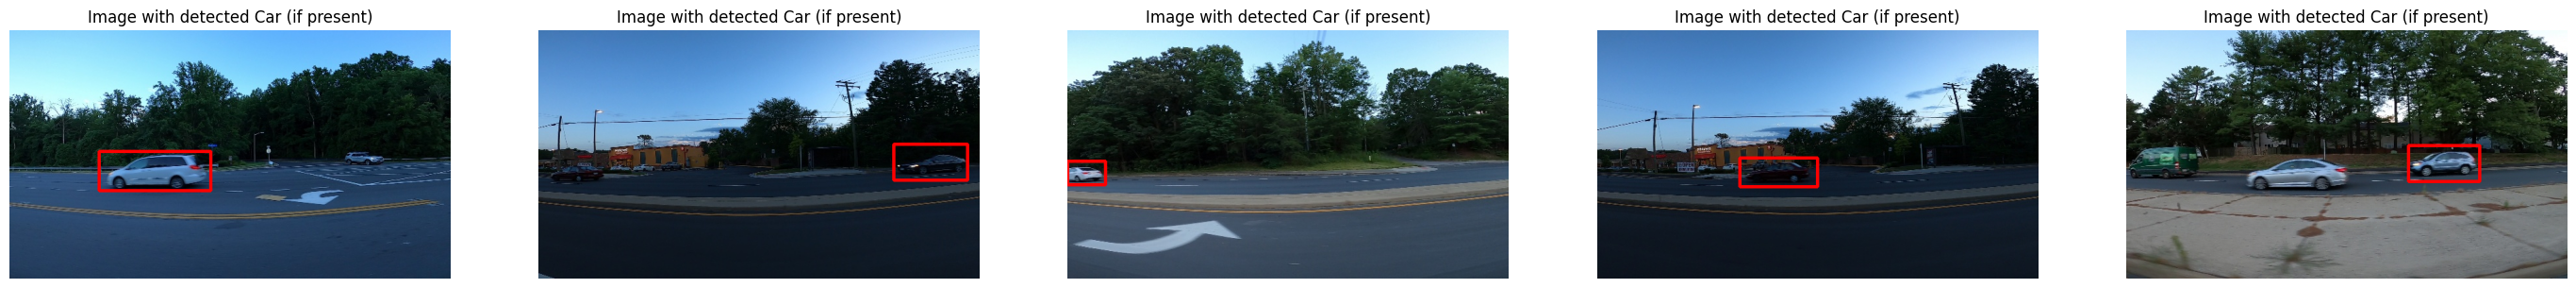

In [ ]:
import random

plt.figure(figsize=(35, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    idx = random.randint(0, bboxes.shape[0] - 1)
    img_path, bbox = bboxes.loc[idx, "image"], tuple(bboxes.iloc[idx, 1:].values)
    img_path = os.path.join(train_data_path, img_path)

    display_image_with_bbox(img_path, [bbox])

Инициализируем модель 11 версии формата nano:

In [16]:
dataset_yaml_path = os.path.join(os.getcwd(), "dataset_custom.yaml")

pretrained_weights = "yolo11n.pt"  # using YOLOv11n

epochs = 30
batch_size = 16
img_size = 640
device = "gpu" if torch.cuda.is_available() else "cpu"

In [ ]:
model = YOLO("yolo11n.pt")

model.train(
    data=dataset_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    device=device,
    verbose=False
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 310MB/s]

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:gpu (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/dataset_custom.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=gpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1768.1±557.4 MB/s, size: 94.3 KB)


train: Scanning /content/data/labels... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<00:00, 2244.27it/s]

train: New cache created: /content/data/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 576.1±180.4 MB/s, size: 101.5 KB)


val: Scanning /content/data/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.31G      1.444      2.996      1.117          7        640: 100%|██████████| 23/23 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  4.00it/s]

                   all        355        355    0.00331      0.992      0.588      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.31G      1.314      1.995      1.121          5        640: 100%|██████████| 23/23 [00:06<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.11it/s]

                   all        355        355    0.00331      0.992     0.0691     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.31G      1.347      2.064       1.16          3        640: 100%|██████████| 23/23 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]

                   all        355        355    0.00323      0.969    0.00917    0.00561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.31G      1.288      1.677      1.116         10        640: 100%|██████████| 23/23 [00:07<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        355        355      0.795     0.0983      0.553      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.31G      1.296      1.646      1.134          4        640: 100%|██████████| 23/23 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


                   all        355        355      0.913      0.118       0.53      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.32G      1.258      1.474      1.096          3        640: 100%|██████████| 23/23 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]

                   all        355        355      0.758      0.583      0.685      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.33G      1.266      1.406      1.103          5        640: 100%|██████████| 23/23 [00:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]

                   all        355        355      0.662      0.307      0.419      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.35G      1.261      1.282        1.1          6        640: 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.93it/s]

                   all        355        355      0.802      0.615      0.763      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.37G      1.226      1.218      1.091          5        640: 100%|██████████| 23/23 [00:06<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        355        355      0.756      0.679      0.746      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.37G      1.249      1.206      1.069          5        640: 100%|██████████| 23/23 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.02it/s]

                   all        355        355      0.752      0.916      0.873      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.37G      1.175      1.108      1.057          7        640: 100%|██████████| 23/23 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]

                   all        355        355      0.859      0.839      0.912      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.37G      1.191       1.04       1.06          4        640: 100%|██████████| 23/23 [00:06<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]

                   all        355        355      0.793      0.797      0.856      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.37G      1.133      1.001      1.043          7        640: 100%|██████████| 23/23 [00:06<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.22it/s]

                   all        355        355      0.769      0.665      0.724      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.37G       1.14     0.9814       1.04          7        640: 100%|██████████| 23/23 [00:05<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]

                   all        355        355      0.795      0.916      0.923      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.37G      1.138     0.9688      1.043          5        640: 100%|██████████| 23/23 [00:07<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]

                   all        355        355      0.846      0.942      0.943      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.37G       1.16     0.9771      1.052          5        640: 100%|██████████| 23/23 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.57it/s]

                   all        355        355       0.82      0.966      0.928      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.37G      1.182     0.9007       1.06          6        640: 100%|██████████| 23/23 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.45it/s]

                   all        355        355      0.843      0.921      0.944      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.37G      1.131     0.8987      1.056          6        640: 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]

                   all        355        355      0.778      0.967      0.907      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.37G      1.135     0.9089      1.041          7        640: 100%|██████████| 23/23 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.77it/s]

                   all        355        355      0.858      0.954      0.949      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.37G      1.121      0.832      1.021          7        640: 100%|██████████| 23/23 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        355        355      0.863       0.94       0.94      0.668


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.37G      1.125     0.9281      1.039          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.00it/s]


                   all        355        355      0.892      0.913      0.959      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.37G      1.097     0.8704      1.043          2        640: 100%|██████████| 23/23 [00:05<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.09it/s]

                   all        355        355      0.901      0.896       0.95      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.37G      1.078     0.8671      1.037          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.87it/s]

                   all        355        355      0.907      0.944      0.964      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.37G      1.081     0.8882      1.008          1        640: 100%|██████████| 23/23 [00:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

                   all        355        355      0.874      0.955      0.952      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.37G       1.08     0.7962      1.017          3        640: 100%|██████████| 23/23 [00:05<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]

                   all        355        355      0.885       0.98      0.958      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.37G      1.075     0.7888      1.022          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]

                   all        355        355       0.89      0.969      0.968      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.37G      1.044      0.772      1.004          2        640: 100%|██████████| 23/23 [00:06<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.63it/s]

                   all        355        355      0.933      0.945      0.982      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.37G      1.053     0.7238      1.008          3        640: 100%|██████████| 23/23 [00:05<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]

                   all        355        355      0.934      0.961      0.985      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.37G      1.044     0.7276      1.016          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]

                   all        355        355      0.942      0.955      0.984      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.37G      1.017     0.7033      1.023          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.05it/s]

                   all        355        355      0.946      0.949      0.985      0.731



30 epochs completed in 0.081 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:gpu (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


                   all        355        355      0.947      0.949      0.985      0.731
Speed: 0.1ms preprocess, 1.9ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f805702c590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
metrics = model.val()
metrics_dict = metrics.results_dict

mAP_50 = metrics_dict['metrics/mAP50(B)']  # mAP at IoU=0.5
mAP_50_95 = metrics_dict['metrics/mAP50-95(B)']

print(f"\nmAP@0.5: {mAP_50}")
print(f"\nmAP@0.5:0.95: {mAP_50_95}")

precision = metrics_dict['metrics/precision(B)']
recall = metrics_dict['metrics/recall(B)']
fitness = metrics_dict['fitness']

print(f"\nPrecision: {precision}")
print(f"\nRecall: {recall}")
print(f"\nFitness: {fitness}")

Ultralytics 8.3.116 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:gpu (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1802.5±214.1 MB/s, size: 104.0 KB)


val: Scanning /content/data/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.60it/s]


                   all        355        355      0.945      0.949      0.985      0.732
Speed: 0.7ms preprocess, 4.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train2

mAP@0.5: 0.9848929415383392

mAP@0.5:0.95: 0.731614286623218

Precision: 0.9454464272041506

Recall: 0.9492957746478873

Fitness: 0.7569421521147301


Получаем очень хорошие результаты после 30 эпох:

mAP50 = 0.985  
mAP50-96 = 0.732

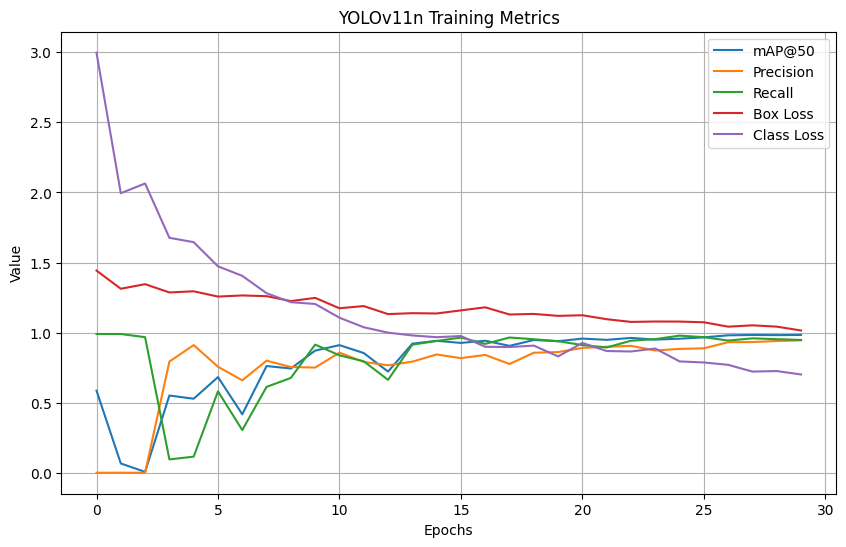

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('runs/detect/train/results.csv')

plt.figure(figsize=(10, 6))
plt.plot(df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['metrics/precision(B)'], label='Precision')
plt.plot(df['metrics/recall(B)'], label='Recall')
plt.plot(df['train/box_loss'], label='Box Loss')
plt.plot(df['train/cls_loss'], label='Class Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('YOLOv11n Training Metrics')
plt.legend()
plt.grid()
plt.show()

In [ ]:
trained_model_dir = os.path.join(os.getcwd(), "model")
trained_model_path = os.path.join(trained_model_dir, "car_detection_yolo.pt")

os.makedirs(trained_model_dir, exist_ok=True)

In [ ]:
model.save(trained_model_path)

Image 1: vid_5_28380.jpg
  Detection 1 - Bounding Box: (np.float32(618.62787), np.float32(168.40392), np.float32(676.0), np.float32(221.56152)), Confidence: 0.81
Image 2: vid_5_29420.jpg
  Detection 1 - Bounding Box: (np.float32(602.2994), np.float32(174.08322), np.float32(675.9513), np.float32(232.4704)), Confidence: 0.78
  Detection 2 - Bounding Box: (np.float32(1.1923186), np.float32(197.69675), np.float32(73.63168), np.float32(232.56633)), Confidence: 0.56
Image 3: vid_5_27920.jpg
  Detection 1 - Bounding Box: (np.float32(138.05257), np.float32(174.3824), np.float32(299.2394), np.float32(249.29427)), Confidence: 0.76
Image 4: vid_5_31360.jpg
  No objects detected


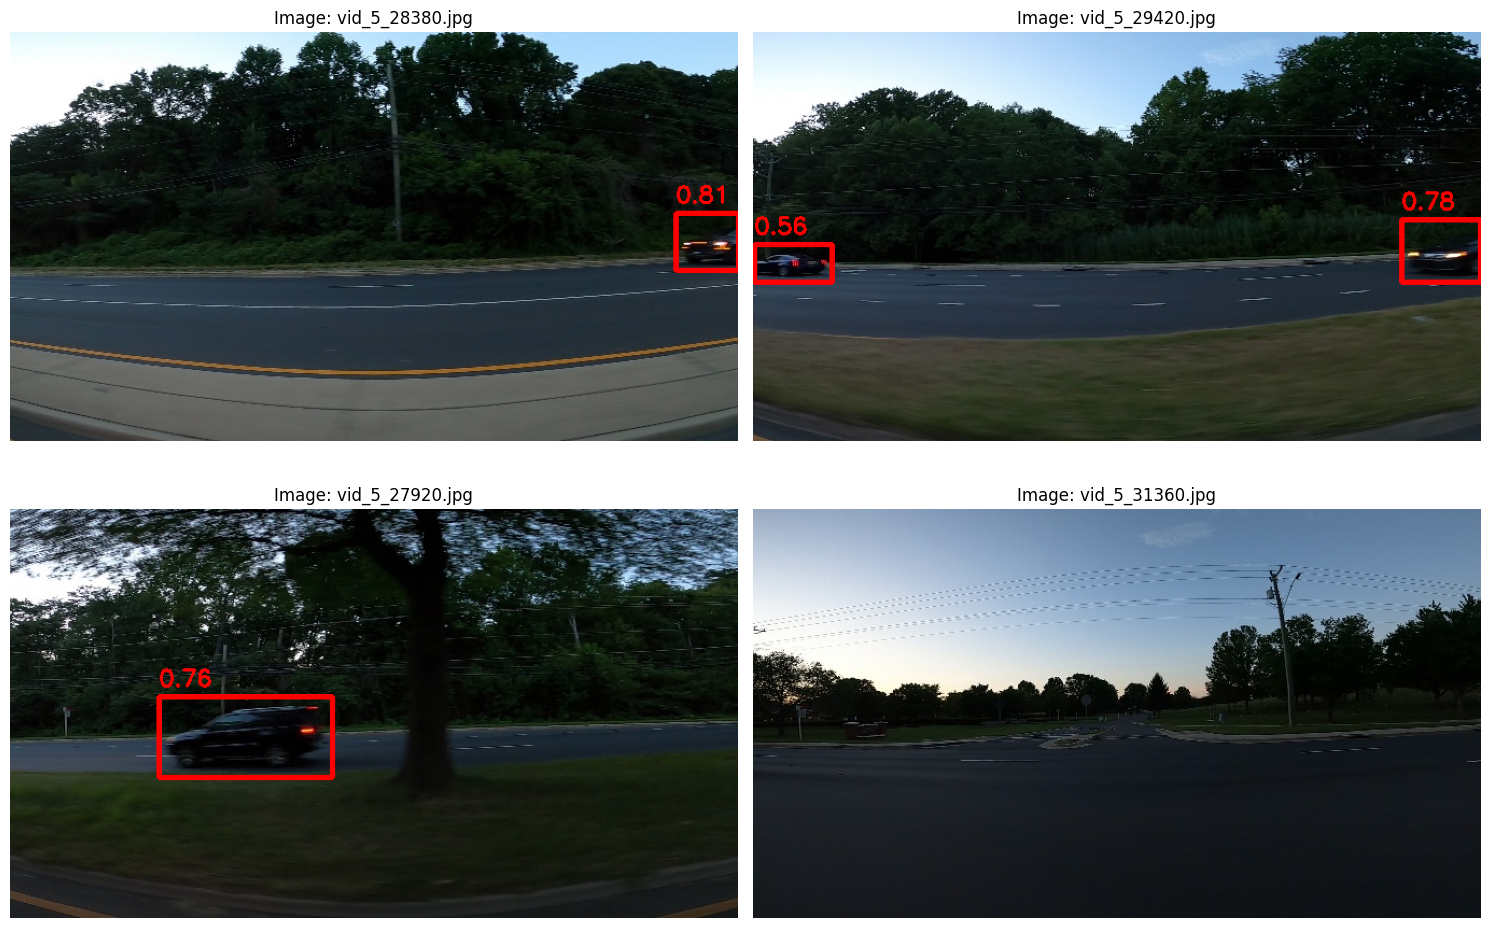

In [ ]:
# Function to visualize predictions on multiple random images
def visualize_multiple_random_images(model, test_data_path, num_images=4):
    # Get list of all image files
    image_files = os.listdir(test_data_path)

    # Create a subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    # Select random images
    for i in range(min(num_images, len(image_files))):
        # Choose a random image
        idx = random.randint(0, len(image_files) - 1)
        image_name = image_files[idx]
        image_path = os.path.join(test_data_path, image_name)

        # Load and process the image
        img = Image.open(image_path)
        results = model(img)

        # Extract bounding boxes and confidence scores
        bboxes = []
        confidences = []

        for result in results:
            boxes = result.boxes
            for box in boxes:
                box = box.cpu()
                xyxy = box.xyxy.numpy()
                bboxes.append(tuple(xyxy[0]))
                confidence = float(box.conf.numpy())
                confidences.append(confidence)

        # Display image with bounding boxes
        image = cv2.imread(image_path)
        if image is not None:
            # Draw rectangles for all bounding boxes
            for j, bbox in enumerate(bboxes):
                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)

                # Display confidence score
                conf_text = f"{confidences[j]:.2f}"
                cv2.putText(image, conf_text, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Convert to RGB for matplotlib
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Display on appropriate subplot
            axes[i].imshow(image_rgb)
            axes[i].axis("off")
            axes[i].set_title(f"Image: {image_name}")

            # Print detection information
            print(f"Image {i+1}: {image_name}")
            if len(bboxes) > 0:
                for j, (bbox, conf) in enumerate(zip(bboxes, confidences)):
                    print(f"  Detection {j+1} - Bounding Box: {bbox}, Confidence: {conf:.2f}")
            else:
                print("  No objects detected")
        else:
            print(f"Failed to read image: {image_path}")
            axes[i].text(0.5, 0.5, "Failed to load image",
                        horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Example usage:
# Call the function with your model and test data path
visualize_multiple_random_images(model, test_data_path, num_images=4)

## 3. Улучшение бейзлайна

Заглядвая немного наперёд, обучение собственной имплементации слишком долгое и большое количество попыток поигать с аугментацией и прочими гиперпараметрами привели к десяткам часов безуспешных ожиданий, так что я решил ограничиться увеличением количества эпох

In [17]:
dataset_yaml_path = os.path.join(os.getcwd(), "dataset_custom.yaml")

pretrained_weights = "yolo11n.pt"  # using YOLOv11n

epochs = 40
batch_size = 16
img_size = 640
device = "0" if torch.cuda.is_available() else "cpu"

In [18]:
model = YOLO("yolo11n.pt")

model.train(
    data=dataset_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    device=device,
    verbose=False
)

Ultralytics 8.3.117 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/dataset_custom.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

train: Scanning /content/data/labels... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<00:00, 2531.16it/s]

train: New cache created: /content/data/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 869.4±616.5 MB/s, size: 101.5 KB)


val: Scanning /content/data/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      2.27G      1.444      2.996      1.117          7        640: 100%|██████████| 23/23 [00:09<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.25it/s]

                   all        355        355    0.00331      0.992      0.588      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      2.28G      1.311       1.99      1.118          5        640: 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        355        355    0.00333          1     0.0594     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40       2.3G      1.344      2.073      1.161          3        640: 100%|██████████| 23/23 [00:05<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]

                   all        355        355    0.00325      0.975     0.0275     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40       2.3G      1.319      1.712       1.15         10        640: 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]

                   all        355        355      0.758       0.15      0.608      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       2.3G      1.285      1.649      1.148          4        640: 100%|██████████| 23/23 [00:05<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]


                   all        355        355      0.813      0.332      0.537      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       2.3G      1.249      1.451      1.102          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.71it/s]

                   all        355        355      0.765      0.634      0.698      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40       2.3G      1.282      1.421      1.118          5        640: 100%|██████████| 23/23 [00:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.78it/s]

                   all        355        355      0.757      0.786      0.833      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      2.33G      1.249      1.318       1.12          6        640: 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.48it/s]


                   all        355        355      0.759      0.913      0.871      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      2.34G      1.259      1.234      1.098          5        640: 100%|██████████| 23/23 [00:05<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.30it/s]

                   all        355        355      0.777      0.933      0.881      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      2.34G      1.255      1.198      1.081          5        640: 100%|██████████| 23/23 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]

                   all        355        355      0.751      0.893      0.851      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      2.34G      1.169      1.099      1.062          7        640: 100%|██████████| 23/23 [00:06<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.80it/s]

                   all        355        355      0.805      0.896      0.907      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      2.34G      1.184      1.029      1.065          4        640: 100%|██████████| 23/23 [00:06<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.47it/s]

                   all        355        355      0.771      0.767      0.831      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      2.34G      1.158     0.9928      1.064          7        640: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]

                   all        355        355      0.741      0.651       0.75      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      2.36G      1.182     0.9874      1.073          7        640: 100%|██████████| 23/23 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]

                   all        355        355      0.813      0.837      0.888      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      2.36G      1.175      0.982       1.07          5        640: 100%|██████████| 23/23 [00:07<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.28it/s]

                   all        355        355      0.717      0.762      0.791       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      2.36G       1.19     0.9806      1.077          5        640: 100%|██████████| 23/23 [00:06<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]

                   all        355        355      0.802      0.896      0.891      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      2.36G      1.181     0.9034      1.073          6        640: 100%|██████████| 23/23 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.32it/s]

                   all        355        355      0.791       0.89      0.875      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      2.36G      1.129     0.9016      1.061          6        640: 100%|██████████| 23/23 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.11it/s]

                   all        355        355      0.816      0.839      0.901       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      2.36G      1.163     0.8939      1.062          7        640: 100%|██████████| 23/23 [00:06<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]

                   all        355        355      0.881      0.761      0.896      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      2.36G       1.17     0.8585      1.049          7        640: 100%|██████████| 23/23 [00:06<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

                   all        355        355      0.805      0.893      0.882       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      2.36G      1.162     0.9086      1.032          3        640: 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.38it/s]

                   all        355        355      0.819      0.915      0.916      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      2.36G      1.138     0.8241      1.042          7        640: 100%|██████████| 23/23 [00:05<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.74it/s]

                   all        355        355      0.864      0.932      0.949      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      2.36G      1.105     0.8134      1.047          6        640: 100%|██████████| 23/23 [00:06<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.55it/s]

                   all        355        355      0.866      0.949      0.949      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      2.36G      1.123     0.7907      1.034          8        640: 100%|██████████| 23/23 [00:05<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

                   all        355        355      0.874      0.897       0.95       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      2.36G        1.1     0.7685      1.023          7        640: 100%|██████████| 23/23 [00:05<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]

                   all        355        355       0.89      0.935      0.963       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      2.36G       1.06     0.7413      1.015          6        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.14it/s]

                   all        355        355       0.92      0.932      0.972      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      2.36G      1.069     0.7656      1.025          7        640: 100%|██████████| 23/23 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.78it/s]

                   all        355        355      0.904       0.95       0.97        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      2.36G      1.032     0.7364      1.011          1        640: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]


                   all        355        355      0.927       0.93      0.977      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      2.36G      1.126     0.7819      1.027          7        640: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]

                   all        355        355      0.887      0.963      0.971      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      2.36G      1.059     0.6904      1.023          6        640: 100%|██████████| 23/23 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]

                   all        355        355      0.887      0.961      0.966      0.706


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      2.36G      1.026     0.7685      1.006          3        640: 100%|██████████| 23/23 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]

                   all        355        355      0.881      0.972      0.959      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      2.36G      1.056     0.7614      1.037          3        640: 100%|██████████| 23/23 [00:05<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

                   all        355        355      0.906      0.952      0.959      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      2.36G      1.001     0.7189      1.007          2        640: 100%|██████████| 23/23 [00:05<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]

                   all        355        355        0.9      0.975      0.975      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      2.36G      1.048     0.6929      1.025          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]

                   all        355        355        0.9      0.952      0.973      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      2.36G     0.9961     0.6448     0.9965          3        640: 100%|██████████| 23/23 [00:05<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        355        355      0.911      0.975      0.982      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      2.36G      1.005     0.6405      1.015          3        640: 100%|██████████| 23/23 [00:05<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]

                   all        355        355       0.94      0.955      0.986      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      2.36G      1.015     0.6565      1.008          1        640: 100%|██████████| 23/23 [00:06<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.00it/s]

                   all        355        355      0.935      0.952      0.982      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      2.36G     0.9915      0.601     0.9953          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]

                   all        355        355      0.929      0.955      0.981      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      2.36G     0.9998     0.6185      1.013          2        640: 100%|██████████| 23/23 [00:05<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]

                   all        355        355      0.954      0.969      0.986      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      2.36G     0.9502     0.5801     0.9652          3        640: 100%|██████████| 23/23 [00:06<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]

                   all        355        355      0.972      0.961      0.989       0.75



40 epochs completed in 0.109 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 5.4MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.117 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.93it/s]


                   all        355        355      0.972      0.961      0.989       0.75
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d0ca3190e10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [19]:
metrics = model.val()
metrics_dict = metrics.results_dict

mAP_50 = metrics_dict['metrics/mAP50(B)']  # mAP at IoU=0.5
mAP_50_95 = metrics_dict['metrics/mAP50-95(B)']

print(f"\nmAP@0.5: {mAP_50}")
print(f"\nmAP@0.5:0.95: {mAP_50_95}")

precision = metrics_dict['metrics/precision(B)']
recall = metrics_dict['metrics/recall(B)']
fitness = metrics_dict['fitness']

print(f"\nPrecision: {precision}")
print(f"\nRecall: {recall}")
print(f"\nFitness: {fitness}")

Ultralytics 8.3.117 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2225.6±1440.3 MB/s, size: 104.0 KB)


val: Scanning /content/data/labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:03<00:00,  6.72it/s]


                   all        355        355      0.972      0.961      0.989      0.749
Speed: 0.8ms preprocess, 3.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train32

mAP@0.5: 0.9885739804090939

mAP@0.5:0.95: 0.7493342277523414

Precision: 0.972155671941082

Recall: 0.9605633802816902

Fitness: 0.7732582030180167


По итогам обучения получаем:

mAP50 = 0.989  
mAP50-95 = 0.749

Видно, что на улучшенном бейзлайне модель увеличила каждую из метрик, что является хорошим результатом

## 4. Имплементация алгоритма машинного обучения


На данном шаге самостоятельно имплементируем простую YOLO

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import box_iou
from PIL import Image
import glob
import numpy as np
from tqdm import tqdm
from collections import defaultdict

Определим ObjectDetectionDataset - интерфейс для работы с датасетом

In [ ]:
class ObjectDetectionDataset(Dataset):
    """
    Dataset class for object detection with YOLO-style annotations.

    Attributes:
        image_paths (list): List of paths to training images
        label_paths (list): List of paths to corresponding label files
        image_size (int): Target size for resizing images
        grid_size (int): Size of the output grid
        num_classes (int): Number of object classes
        transform (torchvision.transforms.Compose): Image transformations
    """
    def __init__(self, image_directory, label_directory, image_size=640, grid_size=7, num_classes=80):
        self.image_paths = sorted(glob.glob(f"{image_directory}/*.jpg"))
        self.label_paths = [os.path.join(label_directory, os.path.basename(p).replace('.jpg', '.txt'))
                          for p in self.image_paths]
        self.image_size = image_size
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """Load and process a single image and its annotations.

        Args:
            index (int): Index of the sample to load

        Returns:
            tuple: (image_tensor, label_tensor) where label_tensor has shape (grid_size, grid_size, 5 + num_classes)
        """
        # Load and transform image
        image = Image.open(self.image_paths[index]).convert('RGB')
        original_width, original_height = image.size
        image_tensor = self.transform(image)

        # Initialize label tensor (grid_y, grid_x, 5 + num_classes)
        # The 5 values are: objectness, x_offset, y_offset, width, height
        label_tensor = torch.zeros((self.grid_size, self.grid_size, 5 + self.num_classes))

        try:
            with open(self.label_paths[index], 'r') as label_file:
                for line in label_file:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())

                    # Determine which grid cell this object belongs to
                    grid_x = int(x_center * self.grid_size)
                    grid_y = int(y_center * self.grid_size)

                    # Calculate offsets within the grid cell
                    cell_x_offset = x_center * self.grid_size - grid_x
                    cell_y_offset = y_center * self.grid_size - grid_y

                    # Fill the label tensor
                    label_tensor[grid_y, grid_x, 0] = 1.0  # Objectness score
                    label_tensor[grid_y, grid_x, 1:5] = torch.tensor([cell_x_offset, cell_y_offset, width, height])
                    label_tensor[grid_y, grid_x, 5 + int(class_id)] = 1.0  # Class one-hot encoding
        except Exception as error:
            print(f"Error processing {self.label_paths[index]}: {error}")

        return image_tensor, label_tensor

Определим саму кастомную Yolo:

In [ ]:
class ObjectDetectionNetwork(nn.Module):
    """
    YOLO-like neural network for object detection.

    Attributes:
        grid_size (int): Number of grid cells along one dimension (default 7x7 grid)
        num_bounding_boxes (int): Number of predicted bounding boxes per grid cell
        num_classes (int): Number of object classes to detect
    """
    def __init__(self, grid_size=7, num_bounding_boxes=2, num_classes=80):
        super().__init__()
        self.grid_size = grid_size
        self.num_bounding_boxes = num_bounding_boxes
        self.num_classes = num_classes

        # Feature extraction backbone network
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(negative_slope=0.1), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(negative_slope=0.1), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(negative_slope=0.1), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(negative_slope=0.1), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), nn.LeakyReLU(negative_slope=0.1),
            nn.AdaptiveAvgPool2d((grid_size, grid_size))  # Output size matches grid size
        )

        # Detection head that predicts bounding boxes and class probabilities
        self.detection_head = nn.Sequential(
            nn.Conv2d(512, (5 * num_bounding_boxes + num_classes), kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()  # Sigmoid activation for confidence scores and class probabilities
        )

    def forward(self, input_images):
        """Forward pass of the network.

        Args:
            input_images (torch.Tensor): Batch of input images (B, C, H, W)

        Returns:
            torch.Tensor: Detection predictions (B, grid_size, grid_size, 5*num_boxes + num_classes)
        """
        features = self.feature_extractor(input_images)
        detections = self.detection_head(features)
        # Rearrange dimensions to (batch, grid_y, grid_x, predictions)
        return detections.permute(0, 2, 3, 1)

In [ ]:
def convert_targets_to_annotations(target_tensors, grid_size):
    """Convert target tensors to annotation format.

    Args:
        target_tensors (torch.Tensor): Batch of target tensors
        grid_size (int): Size of the prediction grid

    Returns:
        list: List of annotations per image
    """
    annotations = []
    for batch_idx in range(target_tensors.size(0)):
        image_annotations = defaultdict(list)

        # Process each grid cell
        for grid_y in range(grid_size):
            for grid_x in range(grid_size):
                if target_tensors[batch_idx, grid_y, grid_x, 0] == 1:
                    # Convert grid coordinates to image coordinates
                    x_center = (grid_x + target_tensors[batch_idx, grid_y, grid_x, 1]) / grid_size
                    y_center = (grid_y + target_tensors[batch_idx, grid_y, grid_x, 2]) / grid_size
                    width = target_tensors[batch_idx, grid_y, grid_x, 3]
                    height = target_tensors[batch_idx, grid_y, grid_x, 4]
                    class_id = torch.argmax(target_tensors[batch_idx, grid_y, grid_x, 5:])

                    # Create bounding box in format [x1, y1, x2, y2, confidence, class_id]
                    bounding_box = [
                        x_center - width/2,  # x_min
                        y_center - height/2, # y_min
                        x_center + width/2,  # x_max
                        y_center + height/2, # y_max
                        1.0,                # confidence (1 for ground truth)
                        class_id.item()     # class ID
                    ]
                    image_annotations[class_id.item()].append(bounding_box)
        annotations.append(image_annotations)
    return annotations

Работа с метриками - mAP50 и mAP50-95 и не только

In [ ]:
def calculate_detection_metrics(predictions, ground_truths, iou_thresholds):
    """Calculate detection metrics (precision, recall, etc.) at various IoU thresholds.

    Args:
        predictions (list): List of predicted detections per image
        ground_truths (list): List of ground truth annotations per image
        iou_thresholds (list): IoU thresholds to evaluate at

    Returns:
        dict: Dictionary containing various evaluation metrics
    """
    metrics = {
        'true_positives': defaultdict(int),
        'false_positives': defaultdict(int),
        'false_negatives': defaultdict(int)
    }

    for iou_threshold in iou_thresholds:
        for image_preds, image_gts in zip(predictions, ground_truths):
            for class_id in range(3):  # Assuming 3 classes for this example
                gt_boxes = [box[:4] for box in image_gts.get(class_id, [])]
                pred_boxes = [box[:5] for box in image_preds.get(class_id, [])]

                # Track which GT boxes have been matched
                matched_gt_indices = np.zeros(len(gt_boxes), dtype=bool)

                for pred_box in pred_boxes:
                    if len(gt_boxes) == 0:
                        metrics['false_positives'][iou_threshold] += 1
                        continue

                    # Calculate IoU between this prediction and all GT boxes
                    ious = box_iou(torch.tensor([pred_box[:4]]), torch.tensor(gt_boxes))
                    max_iou, best_match_idx = torch.max(ious, dim=1)
                    max_iou = max_iou.item()
                    best_match_idx = best_match_idx.item()

                    if max_iou >= iou_threshold and not matched_gt_indices[best_match_idx]:
                        metrics['true_positives'][iou_threshold] += 1
                        matched_gt_indices[best_match_idx] = True
                    else:
                        metrics['false_positives'][iou_threshold] += 1

                metrics['false_negatives'][iou_threshold] += np.sum(~matched_gt_indices)

    # Calculate various metrics from the accumulated counts
    results = {}
    iou_range = np.arange(0.5, 1.0, 0.05)  # For mAP@0.5:0.95

    # Calculate AP at each IoU threshold
    average_precisions = []
    for threshold in iou_range:
        tp = metrics['true_positives'][threshold]
        fp = metrics['false_positives'][threshold]
        fn = metrics['false_negatives'][threshold]
        precision = tp / (tp + fp + 1e-6)
        average_precisions.append(precision)
    results['mean_average_precision_5095'] = np.mean(average_precisions)

    # mAP@0.5
    results['mean_average_precision_50'] = metrics['true_positives'][0.5] / (
        metrics['true_positives'][0.5] + metrics['false_positives'][0.5] + 1e-6)

    # Aggregate metrics across all thresholds
    total_tp = sum(metrics['true_positives'].values())
    total_fp = sum(metrics['false_positives'].values())
    total_fn = sum(metrics['false_negatives'].values())

    results['precision'] = total_tp / (total_tp + total_fp + 1e-6)
    results['recall'] = total_tp / (total_tp + total_fn + 1e-6)
    results['f1_score'] = 2 * (results['precision'] * results['recall']) / (
        results['precision'] + results['recall'] + 1e-6)

    return results

In [ ]:
def process_model_predictions(predictions, grid_size, num_classes, confidence_threshold=0.5):
    """Process raw model predictions into detections.

    Args:
        predictions (torch.Tensor): Raw model predictions
        grid_size (int): Size of the prediction grid
        num_classes (int): Number of object classes
        confidence_threshold (float): Minimum confidence score to keep a detection

    Returns:
        list: List of filtered detections per image
    """
    all_detections = []

    for batch_idx in range(predictions.size(0)):
        image_detections = defaultdict(list)

        # Process each grid cell
        for grid_y in range(grid_size):
            for grid_x in range(grid_size):
                confidence_score = predictions[batch_idx, grid_y, grid_x, 0]
                if confidence_score < confidence_threshold:
                    continue

                # Convert grid coordinates to image coordinates
                x_center = (grid_x + predictions[batch_idx, grid_y, grid_x, 1]) / grid_size
                y_center = (grid_y + predictions[batch_idx, grid_y, grid_x, 2]) / grid_size
                width = predictions[batch_idx, grid_y, grid_x, 3]
                height = predictions[batch_idx, grid_y, grid_x, 4]

                # Get class probabilities and determine the most likely class
                class_probabilities = predictions[batch_idx, grid_y, grid_x, 5:5+num_classes]
                class_id = torch.argmax(class_probabilities)
                class_confidence = class_probabilities[class_id]

                # Create detection box
                detection_box = [
                    x_center - width/2,  # x_min
                    y_center - height/2, # y_min
                    x_center + width/2,  # x_max
                    y_center + height/2, # y_max
                    confidence_score * class_confidence,  # combined confidence
                    class_id.item()      # class ID
                ]
                image_detections[class_id.item()].append(detection_box)

        # Apply non-maximum suppression per class
        for class_id, boxes in image_detections.items():
            # Sort by confidence score (descending)
            boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
            filtered_boxes = []

            while boxes:
                # Take the box with highest confidence
                best_box = boxes.pop(0)
                filtered_boxes.append(best_box)

                # Remove boxes that overlap too much with the best box
                boxes = [box for box in boxes if
                        box_iou(torch.tensor([best_box[:4]]),
                               torch.tensor([box[:4]]))[0][0] < 0.5]  # IoU threshold 0.5

            image_detections[class_id] = filtered_boxes

        all_detections.append(image_detections)
    return all_detections

In [ ]:
def evaluate_model(model, data_loader, grid_size=7, num_classes=80):
    """Evaluate model performance on a dataset.

    Args:
        model (nn.Module): Trained detection model
        data_loader (DataLoader): DataLoader for evaluation data
        grid_size (int): Size of the prediction grid
        num_classes (int): Number of object classes

    Returns:
        dict: Evaluation metrics
    """
    model.eval()
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for images, targets in data_loader:
            # Convert targets to annotation format
            annotations = convert_targets_to_annotations(targets, grid_size)
            all_ground_truths.extend(annotations)

            # Get model predictions
            predictions = model(images)
            detections = process_model_predictions(predictions, grid_size, num_classes)
            all_predictions.extend(detections)

    return calculate_detection_metrics(all_predictions, all_ground_truths,
                                    iou_thresholds=[0.5] + list(np.arange(0.5, 1.0, 0.05)))

In [ ]:
def calculate_bounding_box_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): [x_center, y_center, width, height]
        box2 (list): [x_center, y_center, width, height]

    Returns:
        float: IoU between the boxes
    """
    # Convert from center coordinates to min/max coordinates
    box1_coords = torch.tensor([
        box1[0] - box1[2]/2,  # x_min
        box1[1] - box1[3]/2,  # y_min
        box1[0] + box1[2]/2,  # x_max
        box1[1] + box1[3]/2   # y_max
    ])
    box2_coords = torch.tensor([
        box2[0] - box2[2]/2,
        box2[1] - box2[3]/2,
        box2[0] + box2[2]/2,
        box2[1] + box2[3]/2
    ])
    return box_iou(box1_coords.unsqueeze(0), box2_coords.unsqueeze(0)).item()

Определим коллатор

In [ ]:
def batch_collate_function(batch):
    """Custom collate function for DataLoader to handle our dataset format."""
    images = torch.stack([item[0] for item in batch])
    labels = torch.stack([item[1] for item in batch])
    return images, labels

In [ ]:
def calculate_average_precision(detections, annotations, iou_threshold):
    """Calculate average precision for each class at a specific IoU threshold.

    Args:
        detections (list): List of detections per image
        annotations (list): List of ground truth annotations per image
        iou_threshold (float): IoU threshold for considering a detection correct

    Returns:
        dict: AP scores per class
    """
    average_precisions = {}

    for class_id in range(3):  # Assuming 3 classes for this example
        true_positives = []
        false_positives = []
        ground_truth_count = 0

        for img_idx, (img_dets, img_annots) in enumerate(zip(detections, annotations)):
            gt_boxes = [box[:4] for box in img_annots.get(class_id, [])]
            det_boxes = [box[:5] for box in img_dets.get(class_id, [])]

            tp = np.zeros(len(det_boxes))
            fp = np.zeros(len(det_boxes))
            ground_truth_count += len(gt_boxes)

            if len(gt_boxes) == 0:
                # All detections are false positives if no ground truth
                fp = np.ones(len(det_boxes))
            else:
                gt_tensor = torch.tensor(gt_boxes).view(-1, 4)

                for det_idx, det in enumerate(det_boxes):
                    det_tensor = torch.tensor([det[:4]]).view(-1, 4)

                    # Calculate IoU with all ground truth boxes
                    ious = box_iou(det_tensor, gt_tensor)
                    max_iou = torch.max(ious).item() if gt_tensor.size(0) > 0 else 0.0

                    if max_iou >= iou_threshold:
                        tp[det_idx] = 1
                        # Remove the matched ground truth
                        gt_tensor = gt_tensor[torch.argmax(ious) != torch.arange(gt_tensor.size(0))]
                    else:
                        fp[det_idx] = 1

            # Sort detections by confidence score
            scores = np.array([det[4] for det in det_boxes])
            sort_idx = np.argsort(-scores)
            true_positives.extend(tp[sort_idx])
            false_positives.extend(fp[sort_idx])

        # Convert to numpy arrays for easier calculation
        true_positives = np.array(true_positives)
        false_positives = np.array(false_positives)

        # Calculate precision-recall curve
        tp_cumsum = np.cumsum(true_positives)
        fp_cumsum = np.cumsum(false_positives)

        recalls = tp_cumsum / (ground_truth_count + 1e-6)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)

        # Calculate average precision using 11-point interpolation
        ap = 0
        for threshold in np.linspace(0, 1, 11):
            mask = recalls >= threshold
            if np.any(mask):
                ap += np.max(precisions[mask]) / 11

        average_precisions[class_id] = ap

    return average_precisions

In [ ]:
def train_object_detector(model, train_loader, validation_loader, optimizer, num_epochs=10, grid_size=7, num_classes=80):
    """Train the object detection model.

    Args:
        model (nn.Module): The detection model to train
        train_loader (DataLoader): DataLoader for training data
        validation_loader (DataLoader): DataLoader for validation data
        optimizer (torch.optim.Optimizer): Optimization algorithm
        num_epochs (int): Number of training epochs
        grid_size (int): Size of the prediction grid
        num_classes (int): Number of object classes

    Returns:
        dict: Training history with metrics
    """
    best_mean_ap = 0.0
    training_history = {
        'precision': [],
        'recall': [],
        'f1_score': [],
        'mean_average_precision_50': [],
        'mean_average_precision_5095': []
    }

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        total_objects = 0
        correct_boxes = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, targets in progress_bar:
            optimizer.zero_grad()

            # Forward pass
            predictions = model(images)

            # Reshape for loss calculation
            batch_size = predictions.size(0)
            predictions = predictions.view(batch_size, grid_size * grid_size, -1)
            targets = targets.view(batch_size, grid_size * grid_size, -1)

            # Split predictions into components
            pred_objectness = predictions[..., 0]
            pred_boxes = predictions[..., 1:5]
            pred_classes = predictions[..., 5:5+num_classes]

            # Split targets into components
            target_objectness = targets[..., 0]
            target_boxes = targets[..., 1:5]
            target_classes = targets[..., 5:5+num_classes]

            # Create masks for cells with/without objects
            object_mask = target_objectness == 1
            no_object_mask = target_objectness == 0

            # Calculate loss components
            object_loss = nn.BCELoss()(pred_objectness[object_mask], target_objectness[object_mask])
            no_object_loss = nn.BCELoss()(pred_objectness[no_object_mask], target_objectness[no_object_mask])
            box_loss = nn.MSELoss()(pred_boxes[object_mask], target_boxes[object_mask])
            class_loss = nn.BCELoss()(pred_classes[object_mask], target_classes[object_mask])

            # Combine losses with weighting factors
            total_loss = 5 * box_loss + object_loss + 0.5 * no_object_loss + class_loss
            total_loss.backward()
            optimizer.step()

            # Update metrics
            epoch_loss += total_loss.item()
            total_objects += object_mask.sum().item()

            # Calculate box accuracy (IoU > 0.5)
            with torch.no_grad():
                for i in range(batch_size):
                    for j in range(grid_size * grid_size):
                        if object_mask[i, j]:
                            predicted_box = pred_boxes[i, j]
                            true_box = target_boxes[i, j]
                            if calculate_bounding_box_iou(predicted_box, true_box) > 0.5:
                                correct_boxes += 1

        # Evaluate on validation set
        model.eval()
        validation_metrics = evaluate_model(model, validation_loader, grid_size, num_classes)

        # Store metrics in history
        for key in training_history.keys():
            training_history[key].append(validation_metrics[key])

        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Precision: {validation_metrics['precision']:.4f} | "
              f"Recall: {validation_metrics['recall']:.4f} | "
              f"F1 Score: {validation_metrics['f1_score']:.4f}")
        print(f"mAP@0.5: {validation_metrics['mean_average_precision_50']:.4f} | "
              f"mAP@0.5:0.95: {validation_metrics['mean_average_precision_5095']:.4f}")

        # Save best model
        if validation_metrics['mean_average_precision_5095'] > best_mean_ap:
            best_mean_ap = validation_metrics['mean_average_precision_5095']

    return training_history

Запустим обучение на 10 эпохах (так как даже на 10 это занимает больше часа чтобы убедиться что в целом работает) и посмотрим на результаты:

In [ ]:
# Configuration parameters
GRID_SIZE = 7
NUM_CLASSES = 1  # Assuming 1 class for this example
IMAGE_SIZE = 640
BATCH_SIZE = 8
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

In [ ]:
# Create datasets
train_dataset = ObjectDetectionDataset('data/images', 'data/labels', IMAGE_SIZE, GRID_SIZE, NUM_CLASSES)
validation_dataset = ObjectDetectionDataset('data/images', 'data/labels', IMAGE_SIZE, GRID_SIZE, NUM_CLASSES)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=batch_collate_function)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, collate_fn=batch_collate_function)

In [ ]:
# Initialize model and optimizer
detection_model = ObjectDetectionNetwork(grid_size=GRID_SIZE, num_classes=NUM_CLASSES)
optimizer = optim.Adam(detection_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

In [ ]:
# Train the model
training_history = train_object_detector(
    detection_model,
    train_loader,
    validation_loader,
    optimizer,
    num_epochs=NUM_EPOCHS,
    grid_size=GRID_SIZE,
    num_classes=NUM_CLASSES
)

Epoch 1/10: 100%|██████████| 45/45 [02:57<00:00,  3.95s/it]



Epoch 1 Summary:
Precision: 0.0027 | Recall: 0.0727 | F1 Score: 0.0052
mAP@0.5: 0.0085 | mAP@0.5:0.95: 0.0021


Epoch 2/10: 100%|██████████| 45/45 [03:06<00:00,  4.14s/it]



Epoch 2 Summary:
Precision: 0.0027 | Recall: 0.0366 | F1 Score: 0.0050
mAP@0.5: 0.0097 | mAP@0.5:0.95: 0.0020


Epoch 3/10: 100%|██████████| 45/45 [02:56<00:00,  3.93s/it]



Epoch 3 Summary:
Precision: 0.0265 | Recall: 0.0940 | F1 Score: 0.0413
mAP@0.5: 0.0809 | mAP@0.5:0.95: 0.0210


Epoch 4/10: 100%|██████████| 45/45 [02:59<00:00,  3.99s/it]



Epoch 4 Summary:
Precision: 0.0220 | Recall: 0.1946 | F1 Score: 0.0395
mAP@0.5: 0.0613 | mAP@0.5:0.95: 0.0180


Epoch 5/10: 100%|██████████| 45/45 [02:55<00:00,  3.89s/it]



Epoch 5 Summary:
Precision: 0.0379 | Recall: 0.1772 | F1 Score: 0.0625
mAP@0.5: 0.1103 | mAP@0.5:0.95: 0.0307


Epoch 6/10: 100%|██████████| 45/45 [03:00<00:00,  4.01s/it]



Epoch 6 Summary:
Precision: 0.0528 | Recall: 0.2364 | F1 Score: 0.0864
mAP@0.5: 0.1404 | mAP@0.5:0.95: 0.0441


Epoch 7/10: 100%|██████████| 45/45 [02:57<00:00,  3.94s/it]



Epoch 7 Summary:
Precision: 0.0493 | Recall: 0.2254 | F1 Score: 0.0809
mAP@0.5: 0.1276 | mAP@0.5:0.95: 0.0415


Epoch 8/10: 100%|██████████| 45/45 [02:57<00:00,  3.95s/it]



Epoch 8 Summary:
Precision: 0.0654 | Recall: 0.2817 | F1 Score: 0.1062
mAP@0.5: 0.1622 | mAP@0.5:0.95: 0.0557


Epoch 9/10: 100%|██████████| 45/45 [02:56<00:00,  3.92s/it]



Epoch 9 Summary:
Precision: 0.0853 | Recall: 0.2948 | F1 Score: 0.1324
mAP@0.5: 0.2153 | mAP@0.5:0.95: 0.0723


Epoch 10/10: 100%|██████████| 45/45 [02:56<00:00,  3.92s/it]



Epoch 10 Summary:
Precision: 0.0871 | Recall: 0.3083 | F1 Score: 0.1358
mAP@0.5: 0.2029 | mAP@0.5:0.95: 0.0755


В ходе обучения удалось достигнуть точности 0.2029 по mAP50 и 0.0755 по mAP50-95. Можно сделать вывод, что модели нужно больше эпох для достижения более хороших результатов

Увеличим количество эпох на 9 и посмотрим что из этого выйдет

In [ ]:
# Further training of the model
training_history = train_object_detector(
    detection_model,
    train_loader,
    validation_loader,
    optimizer,
    num_epochs=NUM_EPOCHS,
    grid_size=GRID_SIZE,
    num_classes=NUM_CLASSES
)

Epoch 1/10: 100%|██████████| 45/45 [02:58<00:00,  3.97s/it]



Epoch 1 Summary:
Precision: 0.0757 | Recall: 0.3260 | F1 Score: 0.1229
mAP@0.5: 0.1766 | mAP@0.5:0.95: 0.0656


Epoch 2/10: 100%|██████████| 45/45 [03:00<00:00,  4.00s/it]



Epoch 2 Summary:
Precision: 0.0482 | Recall: 0.2433 | F1 Score: 0.0805
mAP@0.5: 0.1211 | mAP@0.5:0.95: 0.0409


Epoch 3/10: 100%|██████████| 45/45 [02:55<00:00,  3.90s/it]



Epoch 3 Summary:
Precision: 0.1066 | Recall: 0.3155 | F1 Score: 0.1593
mAP@0.5: 0.2483 | mAP@0.5:0.95: 0.0924


Epoch 4/10: 100%|██████████| 45/45 [03:00<00:00,  4.00s/it]



Epoch 4 Summary:
Precision: 0.1593 | Recall: 0.3895 | F1 Score: 0.2261
mAP@0.5: 0.3514 | mAP@0.5:0.95: 0.1401


Epoch 5/10: 100%|██████████| 45/45 [03:01<00:00,  4.02s/it]



Epoch 5 Summary:
Precision: 0.1171 | Recall: 0.3460 | F1 Score: 0.1750
mAP@0.5: 0.2688 | mAP@0.5:0.95: 0.1019


Epoch 6/10: 100%|██████████| 45/45 [02:57<00:00,  3.95s/it]



Epoch 6 Summary:
Precision: 0.1224 | Recall: 0.3334 | F1 Score: 0.1791
mAP@0.5: 0.3009 | mAP@0.5:0.95: 0.1046


Epoch 7/10: 100%|██████████| 45/45 [02:57<00:00,  3.94s/it]



Epoch 7 Summary:
Precision: 0.1576 | Recall: 0.3880 | F1 Score: 0.2241
mAP@0.5: 0.3364 | mAP@0.5:0.95: 0.1397


Epoch 8/10: 100%|██████████| 45/45 [02:57<00:00,  3.95s/it]



Epoch 8 Summary:
Precision: 0.1209 | Recall: 0.3734 | F1 Score: 0.1827
mAP@0.5: 0.2682 | mAP@0.5:0.95: 0.1062


Epoch 9/10: 100%|██████████| 45/45 [02:55<00:00,  3.90s/it]



Epoch 9 Summary:
Precision: 0.1627 | Recall: 0.3562 | F1 Score: 0.2234
mAP@0.5: 0.3616 | mAP@0.5:0.95: 0.1429


Epoch 10/10:  20%|██        | 9/45 [00:35<02:22,  3.97s/it]

В ходе обучения удалось достигнуть точности 0.3616 по mAP50 и 0.1429 по mAP50-95. Архитектура Yolo довольно непроста, поэтому простые самостоятельные имплементации не способны достигнуть точности оригинальной модели с той же скоростью - которая в случае моей задачи достигла очень высоких показателей.

Я мог бы пытаться обучать на гораздо большем количестве эпох, но так как я работаю в Google Collab максимум за раз получится запустить только на 30 эпохах, что сразу же потратит весь мой лимит, что я делать конечно же не буду.